In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from linearmodels import PanelOLS
import scipy.stats as stat

In [5]:

df = pd.read_csv("GoogleBuzzDF.csv")

In [6]:
#many problematic bets, we remove them
df = df.dropna()
df = df.drop(16916, axis = 0)
df = df.drop(16928, axis = 0)



In [7]:
#Extra Removed Bets
df = df.drop(20183, axis = 0)
df = df.drop(18620, axis = 0)
df = df.drop(6884, axis = 0)
df = df.drop(16281, axis = 0)
df = df.drop(20432, axis = 0)

In [8]:
sort_g = df.sort_values("googlebuzz")
#sort_g = df.sort_values("googlebuzz")
sort_g["googlebuzz"] = np.where(sort_g["win"] == 0, -sort_g["googlebuzz"], sort_g["googlebuzz"])
sort_g["originalgooglebuzz"] = np.where(sort_g["win"] == 0, -sort_g["originalgooglebuzz"], sort_g["originalgooglebuzz"])
df = sort_g

In [9]:
#Correlation Matrix
correlation = df[["wikibuzz","googlebuzz","originalgooglebuzz"]]
correlation.rename(columns={'wikibuzz': 'WikiBuzz', 'googlebuzz': 'AbsGoogleBuzz',"originalgooglebuzz":"LogGoogleBuzz"}, inplace=True)
correlation=(correlation-correlation.mean())/correlation.std()
correlation.corr()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


WikiBuzz  AbsGoogleBuzz  LogGoogleBuzz
WikiBuzz       1.000000       0.298694       0.182655
AbsGoogleBuzz  0.298694       1.000000       0.545152
LogGoogleBuzz  0.182655       0.545152       1.000000

In [11]:
#get training data
df["date"] = [dt.date(int(year), int(month), int(day)) for year,month,day in zip(df["year"],df["month"],df["day"])]
df["date"][0]
train_data = df[df["year"]<2019].copy()
test_data = df[df["year"]>=2019].copy()

In [12]:
train_data = train_data.set_index(['match_id'], append=True)
test_data = test_data.set_index(['match_id'], append=True)
test_data = test_data.dropna()
test_data = test_data.sort_values("date")

In [20]:
#Functions
def probability(const_p,odds_p,rankdist_p,wikibuzz_p,year_p,tournament_p,odds,rankdist,wikibuzz,google_p = 0,googlebuzz = 0): #to be used in conjuncture with a df
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz + google_p*googlebuzz)

def _probability(const_p,odds_p,rankdist_p,wikibuzz_p,google_p,odds,rankdist,wikibuzz,googlebuzz):
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz + google_p*googlebuzz)

def kelly_crit(probability,inv_odds):
               return(max((probability-((1-probability)/((1/inv_odds) - 1)),0)))
    
def profit(kelly,inv_odds,win):
    decimal_odds = 1/inv_odds
    if win == 1: #match won
        return(kelly*decimal_odds - kelly) #profits - inital investment
    elif win == 0: #match lost
        return(-kelly) # - initial investment
    

def corrected_kelly_MC(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",_test_odds="inv_max"):
    _test_data(_odds=_odds,rankdist=rankdist,wikibuzz=wikibuzz,googlebuzz=googlebuzz,test_odds = _test_odds)
    test_data['final bankroll'] = (test_data['profit'] + 1).cumprod()
    test_data['prev bankroll'] = test_data["final bankroll"].shift(1)
    test_data['initial bankroll'] = test_data['kelly'] * test_data['prev bankroll']
    test_data['profit initial bankroll'] = test_data['profit'] * test_data['prev bankroll']
    return((((test_data['profit initial bankroll'].sum() + test_data['initial bankroll'].sum()) / test_data['initial bankroll'].sum()) - 1)*100)

def reload_data():
    train_data = df.sample(frac = 0.75)
    test_data = df.drop(train_data.index)
    train_data = train_data.set_index(['match_id'], append=True)
    test_data = test_data.set_index(['match_id'], append=True)
    test_data = test_data.dropna()
    test_data = test_data.sort_values("date")


In [14]:

def plot_train(title = "Traditional ROI"):
    test_data["profit_cum"] = test_data["profit"].cumsum()
    test_data["ROI"] = (((test_data["profit"].cumsum() + test_data["kelly"].cumsum())/test_data["kelly"].cumsum())-1)*100
    test_data.plot('date', 'ROI')
    plt.ylabel('ROI (%)')
    plt.xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.axhline(y=0, color='grey')

def _train_data(odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz"):
    if googlebuzz == False:
        variables = [odds]
    else:
        variables = [odds,googlebuzz]
    if rankdist == True:
        variables.append("rankdist")
    if wikibuzz == True:
        variables.append("wikibuzz")
    exog_vars = train_data[variables]
    exog = sm.add_constant(exog_vars)
    model = PanelOLS(train_data["win"],exog,entity_effects=False)
    results = model.fit()
    x = results.params
    return(x)


In [15]:
def _test_data(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",test_odds = "inv_avg"):
    est = _train_data(_odds,rankdist,wikibuzz,googlebuzz)
    
    const_p,odds_p = est["const"],est["inv_avg"]
    if rankdist == True:
        rankdist_p = est["rankdist"]
    else:
        rankdist_p = 0
    if wikibuzz == True:
        wikibuzz_p = est["wikibuzz"]
    else:
        wikibuzz_p = 0
    
    if googlebuzz == False:
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,0,odds,rankdist,wikibuzz,0) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
    else:
        google_p = est[googlebuzz]
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,google_p,odds,rankdist,wikibuzz,googlebuzz_) for odds,rankdist,wikibuzz,googlebuzz_ in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"],test_data[googlebuzz])]
        
    test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data[test_odds])]
    test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data[test_odds],test_data["win"])]
    test_data["profit"].describe()

def _test_data_mc(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",test_odds = "inv_avg"):
    est = _train_data(_odds,rankdist,wikibuzz,googlebuzz)
    
    const_p,odds_p = est["const"],est["inv_avg"]
    if rankdist == True:
        rankdist_p = est["rankdist"]
    else:
        rankdist_p = 0
    if wikibuzz == True:
        wikibuzz_p = est["wikibuzz"]
    else:
        wikibuzz_p = 0
    
    if googlebuzz == False:
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,0,odds,rankdist,wikibuzz,0) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
    else:
        google_p = est[googlebuzz]
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,google_p,odds,rankdist,wikibuzz,googlebuzz_) for odds,rankdist,wikibuzz,googlebuzz_ in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"],test_data[googlebuzz])]
        
    test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data[test_odds])]
    test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data[test_odds],test_data["win"])]

    return((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100)



In [15]:
pip install alive_progress

Note: you may need to restart the kernel to use updated packages.


In [16]:
from alive_progress import alive_bar

## Run this Cell for Static Bankroll MC

|████████████████████████████████████████| 1000/1000 [100%] in 3:49.5 (4.36/s)   435/1000 [44%] in 1:43 (~2:13, 4.
Ttest_1sampResult(statistic=12.041101636035362, pvalue=2.8123327777863484e-31)


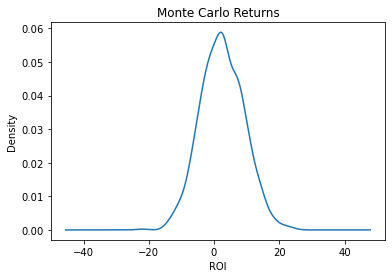

In [24]:
#Static Bankroll MC
roi = list()
with alive_bar(1000,force_tty = True) as bar:
    for i in range(1000):
        train_data = df.sample(frac = 0.75)
        test_data = df.drop(train_data.index)
        train_data = train_data.set_index(['match_id'], append=True)
        test_data = test_data.set_index(['match_id'], append=True)
        test_data = test_data.dropna()
        test_data = test_data.sort_values("date")
        #input new values into _test_data_mc to get results
        #Change test odds [inv_avg,inv_max,inv_bet365]
        # change Rankdist and Wikibuzz [True,False]
        # Change googlebuzz ["originalgooglebuzz","googlebuzz",False]
        # original googlebuzz is the log googlebuzz, googlebuzz is absolute
        roi.append(_test_data_mc(_odds="inv_avg",rankdist=False,wikibuzz=True,googlebuzz="googlebuzz",test_odds = "inv_bet365"))
        bar()
x = pd.DataFrame(roi)
print(x.describe())
x.plot(kind = "density",legend = False)
plt.title("Monte Carlo Returns")
plt.xlabel("ROI")
print(stat.ttest_1samp(roi,0))

## Run this Cell for Dynamic Bankroll

|████████████████████████████████████████| 1000/1000 [100%] in 4:01.6 (4.14/s)  
                 0
count  1000.000000
mean      0.575822
std       2.248063
min      -8.731498
25%      -0.548830
50%       0.233706
75%       1.460352
max      12.939186
Ttest_1sampResult(statistic=8.09989960043038, pvalue=1.5937081388593702e-15)


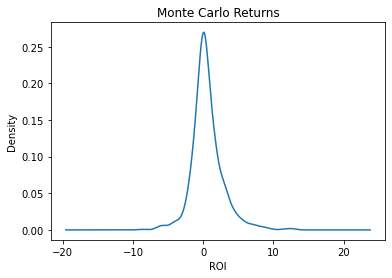

In [23]:
# Dynamic Bankroll MC
roi = list()
with alive_bar(1000,force_tty = True) as bar:
    for i in range(1000):
        train_data = df.sample(frac = 0.75)
        test_data = df.drop(train_data.index)
        train_data = train_data.set_index(['match_id'], append=True)
        test_data = test_data.set_index(['match_id'], append=True)
        test_data = test_data.dropna()
        test_data = test_data.sort_values("date")
        #input new values into _test_data_mc to get results
        #Change test odds [inv_avg,inv_max,inv_bet365]
        # change Rankdist and Wikibuzz [True,False]
        # Change googlebuzz ["originalgooglebuzz","googlebuzz",False]
        # original googlebuzz is the log googlebuzz, googlebuzz is absolute
        roi.append(corrected_kelly_MC(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",_test_odds="inv_max"))
        bar()

x = pd.DataFrame(roi)
print(x.describe())
x.plot(kind = "density",legend = False)
plt.title("Monte Carlo Returns")
plt.xlabel("ROI")
print(stat.ttest_1samp(roi,0))